<a href="https://colab.research.google.com/github/AthiFiz/deepLearning/blob/main/TransferLearning_FeatureExtraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [27]:
import tensorflow as tf

In [28]:
!nvidia-smi

Fri Nov 17 12:15:38 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   63C    P0    30W /  70W |  13049MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [29]:
import zipfile

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip", "r")
zip_ref.extractall()
zip_ref.close()

--2023-11-17 12:15:38--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.197.207, 74.125.135.207, 74.125.142.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.197.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip.2’

10_food_classes_10_ 100%[===================>] 160.74M   195MB/s    in 0.8s    

2023-11-17 12:15:39 (195 MB/s) - ‘10_food_classes_10_percent.zip.2’ saved [168546183/168546183]



In [30]:
import os

for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent

In [31]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224,224)
BATCH_SIZE = 32

train_dir = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

train_datagen = ImageDataGenerator(rescale=1/255)
test_datagen = ImageDataGenerator(rescale=1/255)

train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                            target_size=IMAGE_SHAPE,
                                            batch_size=BATCH_SIZE,
                                            class_mode="categorical")

test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size=IMAGE_SHAPE)

Found 750 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


In [32]:
import datetime

def create_tensorboard_callback(dir_name, experiment_name):

  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)

  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

In [33]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [34]:
resnet_url = "https://www.kaggle.com/models/google/resnet-v2/frameworks/TensorFlow2/variations/50-feature-vector/versions/2"
efficientnet_url = "https://www.kaggle.com/models/google/efficientnet-v2/frameworks/TensorFlow2/variations/imagenet21k-b0-feature-vector/versions/1"

In [35]:
def create_model(model_url, num_classes=10):
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False,
                                           name="feature_extraction_layer",
                                           input_shape=IMAGE_SHAPE+(3,))

  model = tf.keras.Sequential([
      feature_extractor_layer,
      layers.Dense(num_classes, activation="softmax", name="output_layer")
  ])

  return model

In [36]:
resnet_model = create_model(resnet_url, train_data_10_percent.num_classes)

In [37]:
resnet_model.compile(loss="categorical_crossentropy",
                     optimizer = tf.keras.optimizers.Adam(),
                     metrics=["accuracy"])

In [38]:
resnet_history = resnet_model.fit(train_data_10_percent,
                                  epochs=5,
                                  steps_per_epoch=len(train_data_10_percent),
                                  validation_data=test_data,
                                  validation_steps=len(test_data),
                                  callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                         experiment_name="resnet50V2")])

Saving TensorBoard log files to: tensorflow_hub/resnet50V2/20231117-121549
Epoch 1/5
24/24 [==============================] - 27s 678ms/step - loss: 2.0015 - accuracy: 0.3333 - val_loss: 1.1993 - val_accuracy: 0.6240
Epoch 2/5
24/24 [==============================] - 11s 457ms/step - loss: 0.9195 - accuracy: 0.7307 - val_loss: 0.8321 - val_accuracy: 0.7420
Epoch 3/5
24/24 [==============================] - 11s 476ms/step - loss: 0.6382 - accuracy: 0.8253 - val_loss: 0.7533 - val_accuracy: 0.7624
Epoch 4/5
24/24 [==============================] - 11s 474ms/step - loss: 0.4925 - accuracy: 0.8747 - val_loss: 0.7342 - val_accuracy: 0.7572
Epoch 5/5
24/24 [==============================] - 13s 557ms/step - loss: 0.3914 - accuracy: 0.9053 - val_loss: 0.6746 - val_accuracy: 0.7804


In [39]:
# If you wanted to, you could really turn this into a helper function to load in with a helper.py script...
import matplotlib.pyplot as plt

# Plot the validation and training data separately
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

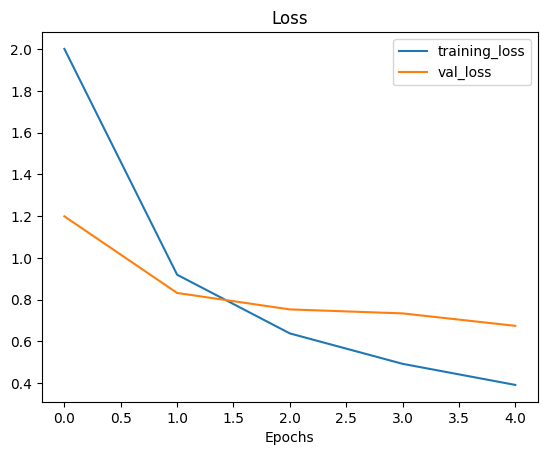

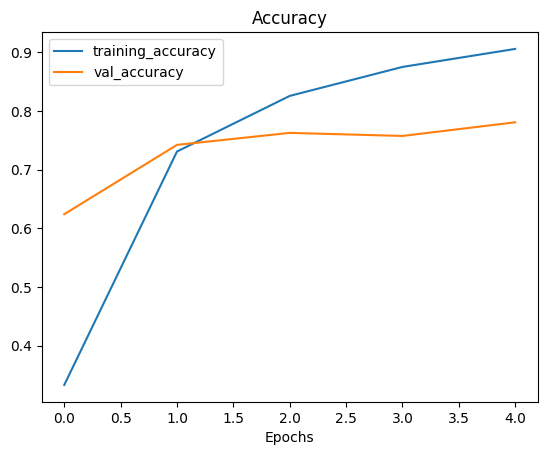

In [40]:
plot_loss_curves(resnet_history)

In [41]:
# Resnet summary
resnet_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (  (None, 2048)              23564800  
 KerasLayer)                                                     
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23585290 (89.97 MB)
Trainable params: 20490 (80.04 KB)
Non-trainable params: 23564800 (89.89 MB)
_________________________________________________________________


In [42]:
# Create model
efficientnet_model = create_model(model_url=efficientnet_url, # use EfficientNetB0 TensorFlow Hub URL
                                  num_classes=train_data_10_percent.num_classes)

# Compile EfficientNet model
efficientnet_model.compile(loss='categorical_crossentropy',
                           optimizer=tf.keras.optimizers.Adam(),
                           metrics=['accuracy'])

# Fit EfficientNet model
efficientnet_history = efficientnet_model.fit(train_data_10_percent, # only use 10% of training data
                                              epochs=5, # train for 5 epochs
                                              steps_per_epoch=len(train_data_10_percent),
                                              validation_data=test_data,
                                              validation_steps=len(test_data),
                                              callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                                     # Track logs under different experiment name
                                                                                     experiment_name="efficientnetB0")])

Saving TensorBoard log files to: tensorflow_hub/efficientnetB0/20231117-121727
Epoch 1/5
24/24 [==============================] - 19s 447ms/step - loss: 1.9026 - accuracy: 0.4307 - val_loss: 0.7253 - val_accuracy: 0.7660
Epoch 2/5
24/24 [==============================] - 11s 489ms/step - loss: 0.5670 - accuracy: 0.8147 - val_loss: 0.4565 - val_accuracy: 0.8504
Epoch 3/5
24/24 [==============================] - 11s 452ms/step - loss: 0.3668 - accuracy: 0.8880 - val_loss: 0.3995 - val_accuracy: 0.8728
Epoch 4/5
24/24 [==============================] - 9s 401ms/step - loss: 0.2701 - accuracy: 0.9320 - val_loss: 0.3803 - val_accuracy: 0.8784
Epoch 5/5
24/24 [==============================] - 10s 442ms/step - loss: 0.1848 - accuracy: 0.9613 - val_loss: 0.3541 - val_accuracy: 0.8932


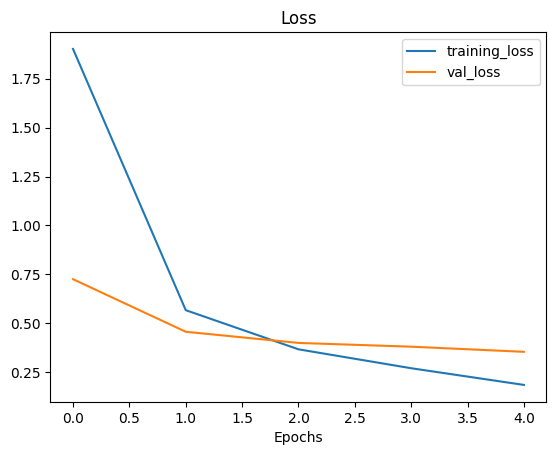

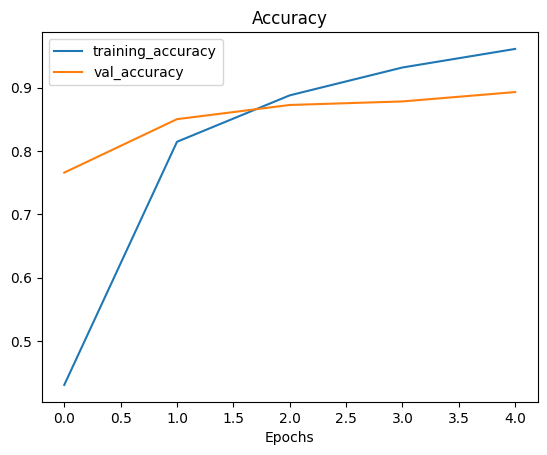

In [43]:
plot_loss_curves(efficientnet_history)

In [44]:
efficientnet_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (  (None, 1280)              5919312   
 KerasLayer)                                                     
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 5932122 (22.63 MB)
Trainable params: 12810 (50.04 KB)
Non-trainable params: 5919312 (22.58 MB)
_________________________________________________________________


In [45]:
# Upload TensorBoard dev records
!tensorboard dev upload --logdir ./tensorflow_hub/ \
  --name "EfficientNetB0 vs. ResNet50V2" \
  --description "Comparing two different TF Hub feature extraction models architectures using 10% of training images" \
  --one_shot

2023-11-17 12:18:39.998676: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-17 12:18:39.998756: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-17 12:18:39.998806: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-17 12:18:40.987029: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT

****************************************************************
****************************************************************
****************************************************************

NOTICE - ACTION REQUIRED: TensorBoard.dev